# 1. All image csv

In [1]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv


# 2. Single hospital image csv

In [2]:
import csv
import os
from collections import defaultdict

def filter_hospital_data(input_csv_path, target_hospital_ids):
    patient_data = defaultdict(list)

    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    hospital_55_data = []
    for images in patient_data.values():
        hospital_55_data.extend(images)

    return hospital_55_data

# Input and output paths
input_csv_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv'
output_folder = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital'
# Single hospital id
target_hospital_ids = ['18']

# Get data for hospital 55
hospital_55_data = filter_hospital_data(input_csv_path, target_hospital_ids)

# Write hospital 55 data to CSV file
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

# Save hospital 55 data to 'hospital55.csv'
write_to_csv(os.path.join(output_folder, 'hospital18.csv'), hospital_55_data)

print("Saved single hospital csv.")


Saved single hospital csv.


# 3. create Random pick data

In [3]:
# import random
# import pandas as pd
# # seed
# random_seed = 123
# random.seed(random_seed)

# # origin csv
# file_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv'
# df = pd.read_csv(file_path)

# # hospital ID
# excluded_hospitals = [18, 43, 55, 100]

# # random pick 3 patients from the rest hospitals
# selected_data = []
# for hospital_id in df['HospitalID'].unique():
#     if hospital_id not in excluded_hospitals:
#         patients = df[df['HospitalID'] == hospital_id]['PatientID'].unique()
#         selected_patients = random.sample(list(patients), min(3, len(patients)))
#         for patient_id in selected_patients:
#             patient_data = df[(df['HospitalID'] == hospital_id) & (df['PatientID'] == patient_id)]
#             selected_data.append(patient_data)

# # concat to new DataFrame
# selected_df = pd.concat(selected_data)

# # create as new csv file
# output_file_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/randompick_patient_data.csv'
# selected_df.to_csv(output_file_path, index=False)

# total_patients = selected_df['PatientID'].nunique()

# total_images = selected_df.shape[0]

# aff_patients = selected_df[selected_df['Label'] == 'AFF']['PatientID'].nunique()

# nff_patients = selected_df[selected_df['Label'] == 'NFF']['PatientID'].nunique()

# nff_images = selected_df[selected_df['Label'] == 'NFF'].shape[0]

# aff_images = selected_df[selected_df['Label'] == 'AFF'].shape[0]

# aff_patient_ratio = aff_patients / total_patients
# nff_patient_ratio = nff_patients / total_patients
# nff_image_ratio = nff_images / total_images
# aff_image_ratio = aff_images / total_images

# print(f"Total Patients: {total_patients}")
# print(f"Total Images: {total_images}")
# print(f"AFF Patients: {aff_patients}")
# print(f"NFF Patients: {nff_patients}")
# print(f"AFF Images: {aff_images}")
# print(f"NFF Images: {nff_images}")
# print(f"AFF Patient Ratio: {aff_patient_ratio:.2f}")
# print(f"NFF Patient Ratio: {nff_patient_ratio:.2f}")
# print(f"AFF Image Ratio: {aff_image_ratio:.2f}")
# print(f"NFF Image Ratio: {nff_image_ratio:.2f}")


# Functions

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import random
def show_image(dataset, num_images=5):
    # Get random indices
    random.seed(1)
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff

# def plot_roc_curve(all_labels, all_predictions):
#     fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
#     roc_auc = roc_auc_score(all_labels, all_predictions)

#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc='lower right')
#     plt.show()

# def test_model(model, test_dataset, batch_size):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
#     model.eval()
    
#     correct_test_nff = 0
#     correct_test_aff = 0
#     total_nff = 0
#     total_aff = 0
#     total_test = 0
#     test_loss = 0
    
#     criterion = nn.CrossEntropyLoss()
    
#     with torch.no_grad():
#         all_predictions = []
#         all_labels = []
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             _, predicted = torch.max(outputs.data, 1)
#             all_predictions.extend(predicted.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             total_test += labels.size(0)
#             total_nff += (labels == 0).sum().item()
#             total_aff += (labels == 1).sum().item()
#             correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
#             correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
#             test_loss += loss.item()

#     test_accuracy_nff = 100 * correct_test_nff / total_nff
#     test_accuracy_aff = 100 * correct_test_aff / total_aff
#     test_accuracy_total = 100 * (correct_test_nff + correct_test_aff) / total_test
#     test_loss /= len(test_loader)
    
#     auc_score = roc_auc_score(all_labels, all_predictions)
#     conf_matrix = confusion_matrix(all_labels, all_predictions)
#     class_labels = {0: 'NFF', 1: 'AFF'}
#     classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    
#     # Store metrics in a dictionary
#     metrics = {
#         "Test Loss": test_loss,
#         "Total Test Accuracy": test_accuracy_total,
#         "Test Accuracy (NFF)": test_accuracy_nff,
#         "Test Accuracy (AFF)": test_accuracy_aff,
#         "AUC": auc_score,
#         "Confusion Matrix": conf_matrix,
#         "Classification Report": classification_rep
#     }
#     plot_roc_curve(all_labels, all_predictions)

#     return metrics


training class weight [0.7590361445783133, 1.4651162790697674]
Image location: /local/data1/honzh073/data/8bit_down224/patient_BEYVSZZZDY_hospital_18_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_NSEIEIKOBO_hospital_18_NFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_SDEGXCSEVI_hospital_18_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_AZZDMRHTOL_hospital_18_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_ITMNMLEHWW_hospital_18_NFF_image_3.png


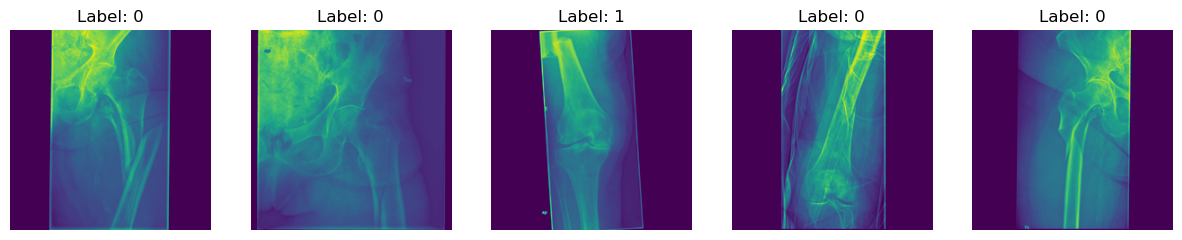

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 43, ratio: 0.34
----- NFF: 83, ratio: 0.66
-----------------------------------


In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
from torchvision import transforms, models
from sklearn.model_selection import KFold

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
from torchvision import transforms

# augmentation
# train_transform = transforms.Compose([
#     transforms.RandomRotation(degrees=30),  # Random rotation up to 10 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
#     transforms.RandomHorizontalFlip(),  # Random horizontal flip
#     transforms.RandomVerticalFlip(),  # Random vertical flip
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random affine transformation (translation up to 10%)
#     transforms.RandomResizedCrop(244, scale=(0.8, 1.0)),  # Random resized crop
#     transforms.RandomAdjustSharpness(sharpness_factor=3),  # Random sharpness adjustment
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))], p=0.5),
    # # transforms.GaussianBlur(kernel_size=3),
    # # transforms.RandomInvert(),
    # # transforms.RandomPosterize(bits=2),
    # transforms.RandomAdjustSharpness(sharpness_factor=5, p=0.5),
    # # transforms.RandomAutocontrast(),
    # transforms.RandomResizedCrop(244, scale=(0.8, 1.0)),  # Random resized crop
    # transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the datasets using CustomDataset class
train_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/hospital18.csv', transform=train_transform)
# test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/randompick_patient_data.csv', transform=test_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

# print images
show_image(train_dataset, 5)

# calculate numbers
print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
# test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
# test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
# print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
# print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
# ------------------------------------------------------------------------------------------------------
def train_custom_model(model, train_dataset, num_epochs, batch_size, optimizer=None):
    classweight = get_classweight(train_dataset) # get_classweight is a function defined above
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):
        print(f'Fold {fold + 1}/{n_splits}')

        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        for epoch in range(num_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100 * correct_train / total_train

            model.eval()
            correct_validation = 0
            total_validation = 0
            validation_loss = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    total_validation += labels.size(0)
                    correct_validation += (predicted == labels).sum().item()
                    validation_loss += loss.item()

            validation_accuracy = 100 * correct_validation / total_validation
            validation_loss /= len(val_loader)

            print(f"Epoch {epoch+1}/{num_epochs}, "
                f"train ACC: {train_accuracy:.2f}%, "
                f"Val ACC: {validation_accuracy:.2f}%")
    return model  # Return the trained model after training is complete

import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
# ------------------------------------------------------------------------------------------------------
def generate_random_pick_dataset(seed, excluded_hospitals, input_csv_path, output_csv_path):
    random.seed(seed)
    
    # Read the original CSV file
    df = pd.read_csv(input_csv_path)
    
    # Randomly select patients from non-excluded hospitals
    selected_data = []
    for hospital_id in df['HospitalID'].unique():
        if hospital_id not in excluded_hospitals:
            patients = df[df['HospitalID'] == hospital_id]['PatientID'].unique()
            selected_patients = random.sample(list(patients), min(3, len(patients)))
            for patient_id in selected_patients:
                patient_data = df[(df['HospitalID'] == hospital_id) & (df['PatientID'] == patient_id)]
                selected_data.append(patient_data)
    
    # Concatenate selected data to create a new DataFrame
    selected_df = pd.concat(selected_data)
    
    # Save the new DataFrame as a CSV file
    selected_df.to_csv(output_csv_path, index=False)
    
    # Return the output file path
    return output_csv_path
# ------------------------------------------------------------------------------------------------------
def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()
    
    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    test_accuracy_nff = 100 * correct_test_nff / total_nff
    test_accuracy_aff = 100 * correct_test_aff / total_aff
    test_accuracy_total = 100 * (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)
    
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    class_labels = {0: 'NFF', 1: 'AFF'}
    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    
    # Store metrics in a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Total Test Accuracy": test_accuracy_total,
        "Test Accuracy (NFF)": test_accuracy_nff,
        "Test Accuracy (AFF)": test_accuracy_aff,
        "AUC": auc_score,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_rep
    }
    return metrics
# ------------------------------------------------------------------------------------------------------
# Set random seed for reproducibility
def run_100_times(model):
    # Define the excluded hospitals and file paths
    excluded_hospitals = [18, 43, 55, 100]
    input_csv_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/all_image.csv'
    output_csv_path = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/randompick_patient_data.csv'

    # Initialize lists to store metrics
    test_metrics_list = []

    # Generate random seeds from 1 to 100
    for seed in range(1, 101):
        print(f"Seed: {seed} / 100", end='\r')
        # Generate random pick dataset
        randompick_patient_data_path = generate_random_pick_dataset(seed, excluded_hospitals, input_csv_path, output_csv_path)
        
        # Load test_dataset using random pick data
        test_dataset = CustomDataset(randompick_patient_data_path, transform=test_transform)  # Define your CustomDataset and transform
        
        # Perform testing and collect metrics
        test_metrics = test_model(model, test_dataset, batch_size=8)  # Use your batch size
        test_metrics_list.append(test_metrics)

    # Calculate mean and standard deviation of metrics
    test_loss_values = [metrics['Test Loss'] for metrics in test_metrics_list]
    total_accuracy_values = [metrics['Total Test Accuracy'] for metrics in test_metrics_list]
    nff_accuracy_values = [metrics['Test Accuracy (NFF)'] for metrics in test_metrics_list]
    aff_accuracy_values = [metrics['Test Accuracy (AFF)'] for metrics in test_metrics_list]
    auc_values = [metrics['AUC'] for metrics in test_metrics_list]

    mean_test_loss = sum(test_loss_values) / len(test_loss_values)
    mean_total_accuracy = sum(total_accuracy_values) / len(total_accuracy_values)
    mean_nff_accuracy = sum(nff_accuracy_values) / len(nff_accuracy_values)
    mean_aff_accuracy = sum(aff_accuracy_values) / len(aff_accuracy_values)
    mean_auc = sum(auc_values) / len(auc_values)

    std_test_loss = (sum((x - mean_test_loss) ** 2 for x in test_loss_values) / len(test_loss_values)) ** 0.5
    std_total_accuracy = (sum((x - mean_total_accuracy) ** 2 for x in total_accuracy_values) / len(total_accuracy_values)) ** 0.5
    std_nff_accuracy = (sum((x - mean_nff_accuracy) ** 2 for x in nff_accuracy_values) / len(nff_accuracy_values)) ** 0.5
    std_aff_accuracy = (sum((x - mean_aff_accuracy) ** 2 for x in aff_accuracy_values) / len(aff_accuracy_values)) ** 0.5
    std_auc = (sum((x - mean_auc) ** 2 for x in auc_values) / len(auc_values)) ** 0.5

    # Print mean and standard deviation values
    # Print mean and standard deviation values with 4 decimal places
    print("Mean Test Loss:", round(mean_test_loss, 4))
    print("Standard Deviation Test Loss:", round(std_test_loss, 4))
    print("Mean Total Accuracy:", round(mean_total_accuracy, 4))
    print("Standard Deviation Total Accuracy:", round(std_total_accuracy, 4))
    print("Mean NFF Accuracy:", round(mean_nff_accuracy, 4))
    print("Standard Deviation NFF Accuracy:", round(std_nff_accuracy, 4))
    print("Mean AFF Accuracy:", round(mean_aff_accuracy, 4))
    print("Standard Deviation AFF Accuracy:", round(std_aff_accuracy, 4))
    print("Mean AUC:", round(mean_auc, 4))
    print("Standard Deviation AUC:", round(std_auc, 4))



# VGG 19

In [25]:
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

v19 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# vgg19_metrics = test_model(model, test_dataset, batch_size=8)
# print(vgg19_metrics)

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 59.00%, Val ACC: 53.85%
Epoch 2/20, train ACC: 76.00%, Val ACC: 61.54%
Epoch 3/20, train ACC: 83.00%, Val ACC: 73.08%
Epoch 4/20, train ACC: 97.00%, Val ACC: 76.92%
Epoch 5/20, train ACC: 94.00%, Val ACC: 42.31%
Epoch 6/20, train ACC: 78.00%, Val ACC: 61.54%
Epoch 7/20, train ACC: 83.00%, Val ACC: 80.77%
Epoch 8/20, train ACC: 96.00%, Val ACC: 76.92%
Epoch 9/20, train ACC: 96.00%, Val ACC: 92.31%
Epoch 10/20, train ACC: 99.00%, Val ACC: 80.77%
Epoch 11/20, train ACC: 99.00%, Val ACC: 65.38%
Epoch 12/20, train ACC: 91.00%, Val ACC: 65.38%
Epoch 13/20, train ACC: 85.00%, Val ACC: 69.23%
Epoch 14/20, train ACC: 90.00%, Val ACC: 73.08%
Epoch 15/20, train ACC: 98.00%, Val ACC: 61.54%
Epoch 16/20, train ACC: 100.00%, Val ACC: 76.92%
Epoch 17/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 18/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 19/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 20/20, train ACC: 100.00%, Val ACC: 84.62%
Fold 2/5
Epoch 1/20, train ACC: 92.

In [26]:
run_100_times(v19)

Mean Test Loss: 2.3915
Standard Deviation Test Loss: 0.1837
Mean Total Accuracy: 65.9951
Standard Deviation Total Accuracy: 1.6078
Mean NFF Accuracy: 65.1792
Standard Deviation NFF Accuracy: 1.6847
Mean AFF Accuracy: 69.9966
Standard Deviation AFF Accuracy: 3.9627
Mean AUC: 0.6759
Standard Deviation AUC: 0.0224


# Inception V3

In [27]:
# from torchvision import models
# from torchvision.models import inception_v3, Inception_V3_Weights

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# # Load the InceptionV3 model pretrained on ImageNet
# model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)

# # Modify the final fully connected layer for binary classification
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 2)  # Assuming you want binary classification (2 classes)

# # Freeze certain layers
# total_layers = len(list(model.children()))
# freeze_layers = int(total_layers * 0.5)
# for index, child in enumerate(model.children()):
#     if index < freeze_layers:
#         for param in child.parameters():
#             param.requires_grad = False

# # Hyperparameters
# num_epochs = 20
# batch_size = 8
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# # 
# transforms = transforms.Compose([
#     transforms.Resize((299, 299)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# train_dataset = 
# # Train the model
# train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# print('####################################################################################')

# # Evaluate the model
# inception_v3_metrics = test_model(model, test_dataset, batch_size=16)
# print(inception_v3_metrics)


# ResNet50

In [28]:
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# print('####################################################################################')
# resnet50_metrics = test_model(model, test_dataset, batch_size=16)
# print(resnet50_metrics)


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 60.00%, Val ACC: 61.54%
Epoch 2/20, train ACC: 95.00%, Val ACC: 65.38%
Epoch 3/20, train ACC: 98.00%, Val ACC: 65.38%
Epoch 4/20, train ACC: 96.00%, Val ACC: 65.38%
Epoch 5/20, train ACC: 100.00%, Val ACC: 73.08%
Epoch 6/20, train ACC: 98.00%, Val ACC: 73.08%
Epoch 7/20, train ACC: 100.00%, Val ACC: 69.23%
Epoch 8/20, train ACC: 98.00%, Val ACC: 80.77%
Epoch 9/20, train ACC: 97.00%, Val ACC: 69.23%
Epoch 10/20, train ACC: 100.00%, Val ACC: 73.08%
Epoch 11/20, train ACC: 100.00%, Val ACC: 73.08%
Epoch 12/20, train ACC: 100.00%, Val ACC: 73.08%
Epoch 13/20, train ACC: 100.00%, Val ACC: 73.08%
Epoch 14/20, train ACC: 100.00%, Val ACC: 73.08%
Epoch 15/20, train ACC: 99.00%, Val ACC: 76.92%
Epoch 16/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 17/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 18/20, train ACC: 100.00%, Val ACC: 76.92%
Epoch 19/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 20/20, train ACC: 100.00%, Val ACC: 80.77%
Fold 2/5
Epoch 1/20, train A

In [29]:
run_100_times(res50)

Mean Test Loss: 1.1543
Standard Deviation Test Loss: 0.0623
Mean Total Accuracy: 58.7228
Standard Deviation Total Accuracy: 1.6424
Mean NFF Accuracy: 56.2395
Standard Deviation NFF Accuracy: 1.806
Mean AFF Accuracy: 70.8291
Standard Deviation AFF Accuracy: 4.0134
Mean AUC: 0.6353
Standard Deviation AUC: 0.0217


# ResNet101

In [30]:
from torchvision.models import resnet101, ResNet101_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# print('####################################################################################')
# resnet50_metrics = test_model(model, test_dataset, batch_size=16)
# print(resnet50_metrics)


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 57.00%, Val ACC: 61.54%
Epoch 2/20, train ACC: 91.00%, Val ACC: 69.23%
Epoch 3/20, train ACC: 95.00%, Val ACC: 69.23%
Epoch 4/20, train ACC: 100.00%, Val ACC: 76.92%
Epoch 5/20, train ACC: 99.00%, Val ACC: 76.92%
Epoch 6/20, train ACC: 98.00%, Val ACC: 76.92%
Epoch 7/20, train ACC: 97.00%, Val ACC: 76.92%
Epoch 8/20, train ACC: 99.00%, Val ACC: 80.77%
Epoch 9/20, train ACC: 99.00%, Val ACC: 80.77%
Epoch 10/20, train ACC: 100.00%, Val ACC: 80.77%
Epoch 11/20, train ACC: 100.00%, Val ACC: 84.62%
Epoch 12/20, train ACC: 97.00%, Val ACC: 76.92%
Epoch 13/20, train ACC: 99.00%, Val ACC: 80.77%
Epoch 14/20, train ACC: 100.00%, Val ACC: 84.62%
Epoch 15/20, train ACC: 100.00%, Val ACC: 84.62%
Epoch 16/20, train ACC: 100.00%, Val ACC: 84.62%
Epoch 17/20, train ACC: 99.00%, Val ACC: 80.77%
Epoch 18/20, train ACC: 97.00%, Val ACC: 84.62%
Epoch 19/20, train ACC: 98.00%, Val ACC: 84.62%
Epoch 20/20, train ACC: 100.00%, Val ACC: 80.77%
Fold 2/5
Epoch 1/20, train ACC: 9

In [31]:
run_100_times(res101)

Mean Test Loss: 0.9993
Standard Deviation Test Loss: 0.0694
Mean Total Accuracy: 67.9053
Standard Deviation Total Accuracy: 2.0639
Mean NFF Accuracy: 64.6889
Standard Deviation NFF Accuracy: 2.0852
Mean AFF Accuracy: 83.5869
Standard Deviation AFF Accuracy: 3.7605
Mean AUC: 0.7414
Standard Deviation AUC: 0.0234


# DenseNet 161

In [32]:
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 20
batch_size = 8
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

dense161 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# print('####################################################################################')
# densenet161_metrics = test_model(model, test_dataset, batch_size=16)
# print(densenet161_metrics)

/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 62.00%, Val ACC: 69.23%
Epoch 2/20, train ACC: 93.00%, Val ACC: 73.08%
Epoch 3/20, train ACC: 99.00%, Val ACC: 84.62%
Epoch 4/20, train ACC: 95.00%, Val ACC: 92.31%
Epoch 5/20, train ACC: 99.00%, Val ACC: 84.62%
Epoch 6/20, train ACC: 96.00%, Val ACC: 80.77%
Epoch 7/20, train ACC: 95.00%, Val ACC: 69.23%
Epoch 8/20, train ACC: 97.00%, Val ACC: 80.77%
Epoch 9/20, train ACC: 98.00%, Val ACC: 76.92%
Epoch 10/20, train ACC: 96.00%, Val ACC: 80.77%
Epoch 11/20, train ACC: 98.00%, Val ACC: 84.62%
Epoch 12/20, train ACC: 99.00%, Val ACC: 88.46%
Epoch 13/20, train ACC: 99.00%, Val ACC: 88.46%
Epoch 14/20, train ACC: 100.00%, Val ACC: 84.62%
Epoch 15/20, train ACC: 95.00%, Val ACC: 88.46%
Epoch 16/20, train ACC: 96.00%, Val ACC: 76.92%
Epoch 17/20, train ACC: 99.00%, Val ACC: 73.08%
Epoch 18/20, train ACC: 99.00%, Val ACC: 92.31%
Epoch 19/20, train ACC: 99.00%, Val ACC: 88.46%
Epoch 20/20, train ACC: 100.00%, Val ACC: 84.62%
Fold 2/5
Epoch 1/20, train ACC: 95.05%

In [33]:
run_100_times(dense161)

Mean Test Loss: 0.5421
Standard Deviation Test Loss: 0.0804
Mean Total Accuracy: 83.2691
Standard Deviation Total Accuracy: 1.8264
Mean NFF Accuracy: 92.1363
Standard Deviation NFF Accuracy: 1.023
Mean AFF Accuracy: 39.7808
Standard Deviation AFF Accuracy: 5.4337
Mean AUC: 0.6596
Standard Deviation AUC: 0.0281


# Efficient B2

In [34]:
# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# # Define the EfficientNetV2-M model
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

# # Access input features of the classifier
# num_features = model.classifier[1].in_features

# # Modify the classifier part of the model
# model.classifier[1] = nn.Linear(in_features=num_features, out_features=2)

# # Freeze certain layers
# total_layers = len(list(model.children()))
# freeze_layers = int(total_layers * 0.5)
# for index, child in enumerate(model.children()):
#     if index < freeze_layers:
#         for param in child.parameters():
#             param.requires_grad = False

# # Hyperparameters
# num_epochs = 20
# batch_size = 8
# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Move model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Train the model
# effi_b2 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)

# # print('####################################################################################')

# # # Evaluate the model
# # efficientnet_b2_metrics = test_model(model, test_dataset, batch_size=16)
# # print(efficientnet_b2_metrics)


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/20, train ACC: 62.00%, Val ACC: 61.54%
Epoch 2/20, train ACC: 54.00%, Val ACC: 50.00%
Epoch 3/20, train ACC: 65.00%, Val ACC: 34.62%
Epoch 4/20, train ACC: 63.00%, Val ACC: 57.69%
Epoch 5/20, train ACC: 70.00%, Val ACC: 61.54%
Epoch 6/20, train ACC: 68.00%, Val ACC: 61.54%
Epoch 7/20, train ACC: 64.00%, Val ACC: 65.38%
Epoch 8/20, train ACC: 75.00%, Val ACC: 65.38%
Epoch 9/20, train ACC: 71.00%, Val ACC: 69.23%
Epoch 10/20, train ACC: 78.00%, Val ACC: 65.38%
Epoch 11/20, train ACC: 73.00%, Val ACC: 65.38%
Epoch 12/20, train ACC: 76.00%, Val ACC: 65.38%
Epoch 13/20, train ACC: 78.00%, Val ACC: 61.54%
Epoch 14/20, train ACC: 77.00%, Val ACC: 65.38%
Epoch 15/20, train ACC: 81.00%, Val ACC: 65.38%
Epoch 16/20, train ACC: 79.00%, Val ACC: 69.23%
Epoch 17/20, train ACC: 77.00%, Val ACC: 65.38%
Epoch 18/20, train ACC: 82.00%, Val ACC: 65.38%
Epoch 19/20, train ACC: 78.00%, Val ACC: 69.23%
Epoch 20/20, train ACC: 78.00%, Val ACC: 61.54%
Fold 2/5
Epoch 1/20, train ACC: 76.24%, 

In [35]:
# run_100_times(effi_b2)

Mean Test Loss: 0.5275
Standard Deviation Test Loss: 0.0153
Mean Total Accuracy: 75.8261
Standard Deviation Total Accuracy: 1.7032
Mean NFF Accuracy: 81.9613
Standard Deviation NFF Accuracy: 1.3333
Mean AFF Accuracy: 45.7475
Standard Deviation AFF Accuracy: 4.9085
Mean AUC: 0.6385
Standard Deviation AUC: 0.0257


In [36]:
# def print_metrics(metrics, model_name):
#     print(f"{model_name} Metrics:")
#     print("Test Loss:", metrics["Test Loss"])
#     print("Total Test Accuracy:", metrics["Total Test Accuracy"])

#     print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
#     print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
#     print("AUC:", metrics["AUC"])
#     print("Confusion Matrix:")
#     print(metrics["Confusion Matrix"])
#     print("Classification Report:")
#     print(metrics["Classification Report"])
#     print("\n")

# # Print metrics for each model
# print_metrics(vgg19_metrics, "VGG-19")
# print_metrics(resnet50_metrics, "ResNet-50")
# print_metrics(resnet101_metrics, "ResNet-101")
# print_metrics(efficientnet_b2_metrics, "ResNet-152")
# print_metrics(densenet161_metrics, "DenseNet-161")


: 